
<div style="text-align: center; font-weight: bold;">
    <h1>Generating Research ready EHR Datasets</h1>
    <h2>Part 1: Accessing, Understanding and Summarizing EHR Data</h2>
    <h4>Author: Vidul Ayakulangara Panickan</h3>
</div>




**How the Tutorial is Structured**  

The tutorial is divided into three parts:  

Part 1: Accessing, Understanding, and Summarizing EHR Data  
Part 2: Cleaning, Organizing, and Rolling Up EHR Data  
Part 3: Cohort Creation, NLP and Aggregating the processed EHR Data  

The tutorial is designed with steps that flow across all three parts, starting from Step 1 and continuing through to Step 6.  

If a step involves processing data, we will first go through the basic operations one by one. Then, we will create functions that perform these operations so they can be reused for processing other datasets in this tutorial.  

**Prerequisites:**  
1. Basic knowledge of Python programming
2. Access to MIMIC-IV 3.1 data
3. Harvard O2 account – running the tutorial on the O2 Cluster is recommended.
4. A [UMLS](https://www.nlm.nih.gov/research/umls/index.html) account


## Gaining Access to MIMIC-IV Dataset

MIMIC-IV is a deidentified EHR dataset sourced from BIDMC Hospital. To gain access to MIMIC-IV, follow these steps

1. You will need to be a credentialed user. You can register in [here](https://physionet.org/register/) to create a physionet account and become a credential user
2. Complete the training listed [here](https://physionet.org/content/mimiciv/view-required-training/3.1/) and submit the trainings [here](https://physionet.org/settings/training/)
3. Sign the Data User Agreement [here](https://physionet.org/login/?next=/sign-dua/mimiciv/3.1/)

You will be notified via your registered email once the access is approved.

## Setting up your Compute Environment


We recommend using the Harvard O2 cluster for processing. Log in to your O2 account and run the following terminal commands from any directory to set up the workspace, download MIMIC data, and install the required libraries:

```bash
wget https://raw.githubusercontent.com/apvidul/setup-scripts/refs/heads/main/setup_ehr_tutorial_mimic4_codi_nlp.sh

# Set location of your workspace on line 2 once setup_ehr_tutorial_mimic4_codi_nlp.sh has been downloaded
nano setup_ehr_tutorial_mimic4_codi_nlp.sh

sh setup_ehr_tutorial_mimic4_codi_nlp.sh
```

The script will submit `sbatch` jobs to download the MIMIC data to your target workspace.  
The download process will take approximately **5 hours** to complete.  To monitor the download progress, check the log file generated in the  `EHR_TUTORIAL_WORKSPACE/scripts` directory.  Once the `setup_ehr_tutorial_mimic4_codi_nlp.sh` script has finished executing,  the `EHR_TUTORIAL_WORKSPACE` will be created with the following directory structure:


```bash      
EHR_TUTORIAL_WORKSPACE/
├── raw_data         # The downloaded MIMIC-IV data will be stored here
├── processed_data   # The processed data will be generated here as you work through the notebooks
└── scripts          # Directory for Python notebooks and mimic download status will be stored here
```

Once MIMIC is downloaded, you are ready to work on this notebook. The data is currently in zipped format, you can go ahead and run the following block to unzip.

In [1]:
import os

# Specifice the tutorial workspace location below
LOCATION = "/n/scratch/users/v/va67/EHR_TUTORIAL_WORKSPACE"

# Build the path to the .gz files using os.path.join
hosp_gz_files_path = os.path.join(LOCATION, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp")

# Run the gunzip command directly in the IPython notebook
print("Please wait, files are being unzipped")
!gunzip {hosp_gz_files_path}/*.gz
print(f"All .gz files in {hosp_gz_files_path} have been unzipped.\n")

note_gz_files_path = os.path.join(LOCATION, "raw_data", "nlp", "physionet.org", "files", "mimic-iv-note", "2.2", "note")
!gunzip {note_gz_files_path}/*.gz

print(f"All .gz files in {note_gz_files_path} have been unzipped.\n")


Please wait, files are being unzipped
gzip: /n/scratch/users/v/va67/EHR_TUTORIAL_WORKSPACE/raw_data/physionet.org/files/mimiciv/3.1/hosp/*.gz: No such file or directory
All .gz files in /n/scratch/users/v/va67/EHR_TUTORIAL_WORKSPACE/raw_data/physionet.org/files/mimiciv/3.1/hosp have been unzipped.

gzip: /n/scratch/users/v/va67/EHR_TUTORIAL_WORKSPACE/raw_data/nlp/physionet.org/files/mimic-iv-note/2.2/note/*.gz: No such file or directory
All .gz files in /n/scratch/users/v/va67/EHR_TUTORIAL_WORKSPACE/raw_data/nlp/physionet.org/files/mimic-iv-note/2.2/note have been unzipped.



## Step 1: Understanding the Data
After gaining access to the raw EHR data, the first step is to understand

1. Where all the components of the data are stored.
2. How the data is structured and interconnected.
3. The key concepts and elements within the data.

The EHR data typically includes its own documentation, or you can consult a data maintainer for further details. For MIMIC data, comprehensive documentation is provided [here](https://mimic.mit.edu/docs/iv/)

We recommend to watch the video tutorial [here](https://mimic.mit.edu/docs/iv/tutorials/video/)

### Where is the Data Stored?
EHR data is typically stored in databases. However sometimes, for research and analysis purposes they are also provided as flat files. 

For MIMIC, the datasets are provided as compressed csv files and is located in /files/mimiciv/3.1/ under two modules: icu and hosp in compressed format.

MIMIC-IV data comes in “modules” based on the source of data generations. Following are the five modules:

- [hosp](https://mimic.mit.edu/docs/iv/modules/hosp/) - Hospital-level data for patients, including labs, microbiology, and electronic medication administration records.  
- [icu](https://mimic.mit.edu/docs/iv/modules/icu/) - ICU-level data, including event tables (e.g., chartevents) identical in structure to MIMIC-III.  
- [ed](https://mimic.mit.edu/docs/iv/modules/ed/) - Data from the emergency department.  
- [cxr](https://mimic.mit.edu/docs/iv/modules/cxr/) - Lookup tables and metadata from MIMIC-CXR, enabling linkage to MIMIC-IV.  
- [note](https://physionet.org/content/mimic-iv-note/2.2/) - De-identified free-text clinical notes.  

We will be primarily working with [MIMIC-IV](https://physionet.org/content/mimiciv/3.1/) hosp module and note module. 


### How is the Data Organized?


#### Hosp Module: 
Consists of  all data acquired from the hospital wide electronic health record. This includes patient information, lab measurements, microbiology, medication administered, and billed diagnoses. Information on tables in this module can be read [here](https://mimic.mit.edu/docs/iv/modules/hosp/)

Depending on the needs of your research/analysis you will have multiple tables of interest. Below we list the major ones we will need for this tutorial.

#### 1. **Data Dictionaries**
These tables contain definitions for the medical codes used in the EHR data:

- **`d_hcpcs`**: Provides descriptions of CPT codes.
- **`d_icd_diagnoses`**: Provides descriptions of ICD-9/ICD-10 billed diagnoses.
- **`d_icd_procedures`**: Provides descriptions of ICD-9/ICD-10 billed procedures.
- **`d_labitems`**: Provides descriptions of all lab items.

---

#### 2. **Event Tables**
These tables contain events recorded in the hospital.

##### **Diagnosis Data**
- **`diagnoses_icd`**: Billed ICD diagnosis codes for hospitalizations.

##### **Medication Data**
- **`prescriptions`**: Provides information about prescribed medications.

##### **Lab Data**
- **`labevents`**: Laboratory measurements sourced from patient-derived specimens.

##### **Procedure Data**
- **`hpcsevents`**: Billed events occurring during hospitalization, including CPT codes.
- **`procedures_icd`**: Billed procedures for patients during their hospital stay.

---

#### 3. **Patient Metadata**
These tables provide information about patients during their hospital stays:

- **`admissions`**: Detailed information about hospital stays.
- **`transfers`**: Detailed information about patients' unit transfers.
- **`patients`**: Includes patients' gender, age, and date of death (if available).
   

#### ICU Module: 
Consists of information collected from the clinical information system used within the ICU. Data includes intravenous administrations, ventilator settings, and other charted items. Information on tables in this module can be read [here](https://mimic.mit.edu/docs/iv/modules/icu/)

### Key Concepts in the Data

1. **Unique Patient ID**: A unique id that uniquely identifies a patient. In MIMIC data, every unique patient get a unique id called subject_id
2. **Event/Observation**: EHR data largely includes events or observation recorded over a period of time.
3. **Event/Observation Type**: Type of Event/Observation type that is recorded or observed. This can be Diagnosis, Medication, Lab, Procedure, Radiology, Note etc
4. **Time**: Time an event happened or observation was made
   

## Step 2: Summarize The Data

Our objective is to understand the structure of the EHR data and its key characteristics. For example

1. Determining the total number of unique patients under each subtables like diagnoses, medication etc 
2. Identify distinct EHR codes, type of code and how frequent they appear in the dataset 
3. Identify data quality issues, including outliers and missing values


First, we will load all the libraries we need for this step and ensure our base_directory point to our workspace location

In [5]:
import pandas as pd
import os
from collections import defaultdict

base_directory = os.path.dirname(os.getcwd()) 
print(base_directory)

/n/scratch/users/v/va67/EHR_TUTORIAL_WORKSPACE


In [6]:
# We will create a directory to store summary data we will generate 
summary_directory = os.path.join(base_directory, 'processed_data', 'Summary')

print(f"Creating Summary directory here {summary_directory}")

os.makedirs(summary_directory, exist_ok=True)

Creating Summary directory here /n/scratch/users/v/va67/EHR_TUTORIAL_WORKSPACE/processed_data/Summary


In [7]:
# Summarizing Patient Demographics

demographics_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","patients.csv")

demographics = pd.read_csv(demographics_file,dtype=str)

display(demographics.head())

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
0,10000032,F,52,2180,2014 - 2016,2180-09-09
1,10000048,F,23,2126,2008 - 2010,NaN
2,10000058,F,33,2168,2020 - 2022,NaN
3,10000068,F,19,2160,2008 - 2010,NaN
4,10000084,M,72,2160,2017 - 2019,2161-02-13


In [8]:
display(demographics.describe())

print(demographics.isna().sum())

,subject_id,gender,anchor_age,anchor_year,anchor_year_group,dod
count,364627,364627,364627,364627,364627,38301
unique,364627,2,73,99,5,22424
top,10000032,F,20,2165,2008 - 2010,2142-01-06
freq,1,191984,11031,4700,101607,7


subject_id                0
gender                    0
anchor_age                0
anchor_year               0
anchor_year_group         0
dod                  326326
dtype: int64


There are in total `364,627` patients in the MIMIC-IV hospital dataset. Around `52%` are female. The patients table contains date of death for `38,301` patients.

### Summarizing Diagnoses Data

In U.S. healthcare systems, diagnoses are primarily documented using **ICD (International Classification of Diseases)** codes.

There are two versions of ICD codes in use:  
- **ICD-9**: used until **October 1, 2015**  
- **ICD-10**: starting **October 1, 2015**

It's important to note that the same diagnosis might be represented by different codes, depending on whether it was documented before or after the transition in 2015. For a detailed comparison between ICD-9 and ICD-10 codes, you can read more [here](https://www.ama-assn.org/media/7546/download).

In [9]:
# Loading the tables as string format makes the data consistent throughout. 
diagnoses_icd_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","diagnoses_icd.csv")

diagnoses_icd = pd.read_csv(diagnoses_icd_file,dtype=str)

# We begin by examining first few rows of the data to get a sense of its structure
display(diagnoses_icd.head())

,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


In [10]:
# We summarize the data

diagnoses_icd.describe()

,subject_id,hadm_id,seq_num,icd_code,icd_version
count,6364488,6364488,6364488,6364488,6364488
unique,223291,545497,39,28562,2
top,12468016,27635276,1,4019,10
freq,2396,57,545507,102368,3455747


From above, we can see that there are **`223,291`** patients in the `diagnoses_icd` table, which is **`68%`** of the total patients we saw in the patients table.  

It is crucial to identify and account for every medical code in the EHR data, as overlooking them can result in large-scale missing data, potentially compromising the results of your analysis. From the table above, we observe that there are **`28,562`** unique ICD codes.

In the example above, we load the entire dataset at once because the diagnosis dataset is relatively small. 
However, for larger datasets, such as laboratory data or ECG data points, alternative methods are needed to handle the data efficiently. Below, we define a custom summarization function designed to process larger datasets. This function reads the data in batches, 
summarizes it, and provides the frequency distribution of individual EHR elements.

In [11]:
def get_basic_summary(filepath, batch_size):
    
    frequencies = defaultdict(lambda: defaultdict(int))
    non_null_records_count = defaultdict(int)
    total_records_count = 0

    for batch in pd.read_csv(filepath, chunksize=batch_size, dtype=str):
        total_records_count += len(batch)

        for column in batch.columns:
            non_null_records_count[column] += batch[column].notnull().sum()
    
            value_counts = batch[column].value_counts()
            for value, count in value_counts.items():
                frequencies[column][value] += count
                
    freq_table = [
        (column, len(frequencies[column]), non_null_records_count[column])
        for column in frequencies
    ]

    summary = pd.DataFrame(freq_table, columns=["Column_Name", "Unique_Values", "Non_Null_Records"])
    
    return {'summary':summary,'column_freq':frequencies,'records':total_records_count}

In [12]:
# Summarizing the data using the function defined above. 
batch_size = 5000000

summarize_output= get_basic_summary(diagnoses_icd_file, batch_size)

print("Total number of records in diagnoses icd file :", summarize_output['records'])

# Saving the summary to Summary folder
summarize_output['summary'].to_csv(os.path.join(summary_directory,"diagnoses_basic_summary.csv"),index=None)

summarize_output['summary']

Total number of records in diagnoses icd file : 6364488


,Column_Name,Unique_Values,Non_Null_Records
0,subject_id,223291,6364488
1,hadm_id,545497,6364488
2,seq_num,39,6364488
3,icd_code,28562,6364488
4,icd_version,2,6364488


Since we are now processing in batches, we can reuse the above function to handle larger datasets

In [13]:
# Next we'll count how freqeunt each column item appears in the diagnoses_icd and sort them by frequency 

import heapq

column_frequencies = summarize_output["column_freq"]

for col, freq_data in column_frequencies.items():
    top_frequencies = heapq.nlargest(5, freq_data.items(), key=lambda x: x[1])
    freq_df = pd.DataFrame(top_frequencies, columns=[col, f"{col}_count"])
    display(freq_df)

,subject_id,subject_id_count
0,12468016,2396
1,18284271,2077
2,10577647,1850
3,15114531,1840
4,11582633,1777


,hadm_id,hadm_id_count
0,27635276,57
1,23076003,50
2,24773199,42
3,23416936,39
4,25781318,39


,seq_num,seq_num_count
0,1,545507
1,2,531552
2,3,508643
3,4,482201
4,5,452724


,icd_code,icd_code_count
0,4019,102368
1,E785,84570
2,I10,83775
3,2724,67293
4,Z87891,62806


,icd_version,icd_version_count
0,10,3455747
1,9,2908741


From above, we can conclude that the most frequently appearing ICD code is `4019` which corresponds to `Unspecified essential hypertension`

Also we see that there are more ICD-10 codes recorded than ICD-9 codes in the dataset.  

You can also count unique pairs of `ICD codes` and `subject_id` to determine how many patients had a particular ICD code. This information is essential to identifying the size of a patient cohort for research focused on a specific disease.

In [14]:
unique_subject_icd_pairs = diagnoses_icd[['subject_id', 'icd_code','icd_version']].drop_duplicates()

icdcode_frequencies = unique_subject_icd_pairs[['icd_code','icd_version']].value_counts().reset_index(name='counts')

sorted_icdcode_frequencies = icdcode_frequencies.rename(columns={'index': 'icd_code'}).sort_values(by='counts', ascending=False)

display(sorted_icdcode_frequencies.head())

,icd_code,icd_version,counts
0,4019,9,52360
1,I10,10,48611
2,E785,10,45431
3,2724,9,35210
4,Z87891,10,32523


Great! Now we know we have around 50k patients with the ICD code 4019 and 48k patients with the ICD code I10 and so on, among others.   

However, at this point, we do not know what these ICD codes correspond to. Typically, EHR datasets come with data dictionaries that provide EHR codes and their definitions. For MIMIC-IV, the ICD codes defenitions are provided in the `d_icd_diagnoses` table.

In [15]:
d_icd_diagnoses_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","d_icd_diagnoses.csv")

# Ensure that we load the dictionary in the same format as the original dataset. Here we load everything as string
data_dictionary_icd = pd.read_csv(d_icd_diagnoses_file,dtype=str)

# Display the top rows
display(data_dictionary_icd.head())

,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


In [16]:
#Now we combine the two datasets to get the icd code frequency along with icd code descriptions

sorted_icdcode_frequencies_w_def = pd.merge(sorted_icdcode_frequencies, data_dictionary_icd, on=['icd_code','icd_version'], how='left')

sorted_icdcode_frequencies_w_def.to_csv(os.path.join(summary_directory,'diagnoses_patient_count.csv'),index=None)

sorted_icdcode_frequencies_w_def.head()

,icd_code,icd_version,counts,long_title
0,4019,9,52360,Unspecified essential hypertension
1,I10,10,48611,Essential (primary) hypertension
2,E785,10,45431,"Hyperlipidemia, unspecified"
3,2724,9,35210,Other and unspecified hyperlipidemia
4,Z87891,10,32523,Personal history of nicotine dependence


### <span style="color: #d9534f;">Important Note</span>

As you can see both **4019** and **I10** correspond to hypertension, but they come from different versions of ICD. If you are conducting a study on hypertension, your patient cohort should include all ICD codes corresponding to hypertension, including **4019** and **I10**.

Let's go ahead and plot a wordcloud of ICD Code defenitions based on the frequency they appear in MIMIC-IV Diagnoses data

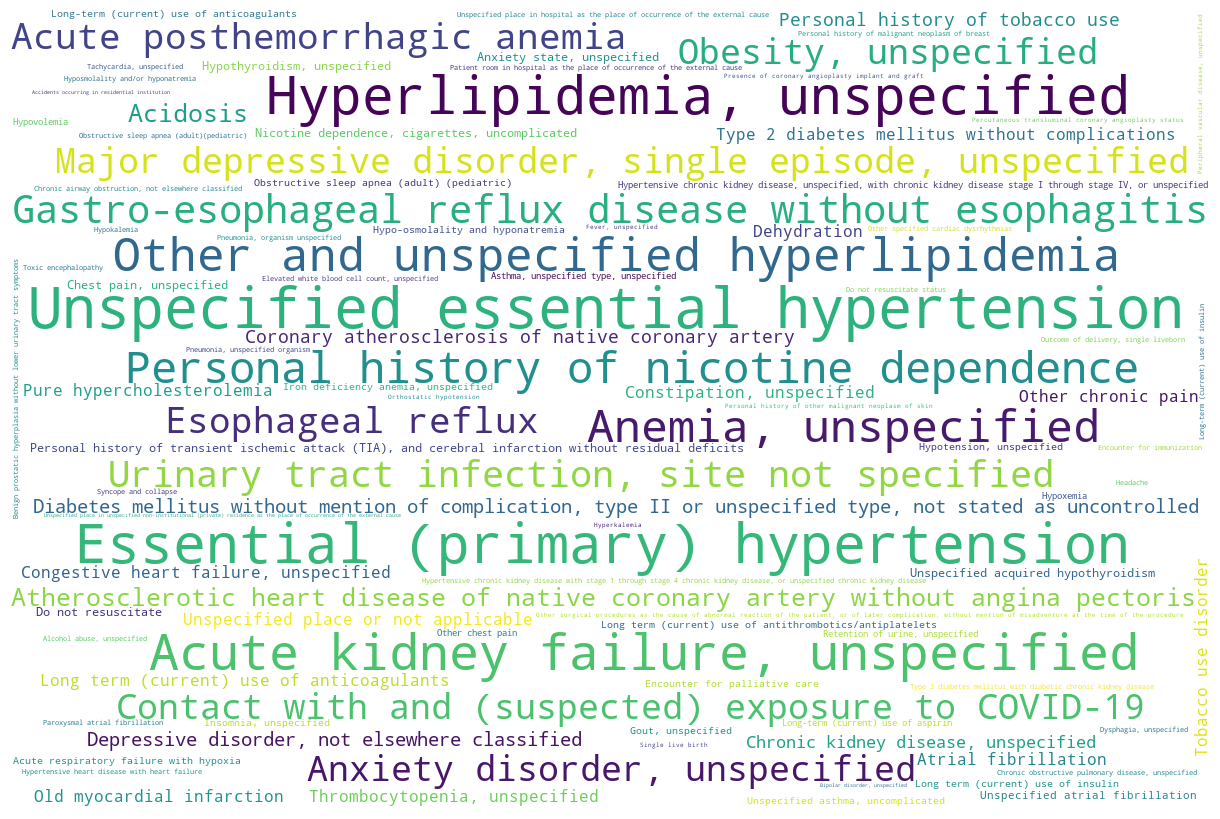

In [17]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a dictionary for the word cloud
word_freq = {}
for index, row in sorted_icdcode_frequencies_w_def.iterrows():
    title = row['long_title']
    count = row['counts']
    word_freq[title] = word_freq.get(title, 0) + count

# Customize the WordCloud
wordcloud = WordCloud(
    width=1200,           # Higher resolution
    height=800,
    background_color='white',  # Professional clean background
    colormap='viridis',   # Professional color palette
    prefer_horizontal=0.9,  # Mostly horizontal layout
    max_words=100,        # Limit number of displayed titles
    contour_width=1,      # Add a border
    contour_color='black', # Border color
    font_path=None        # You can use a professional font (optional)
).generate_from_frequencies(word_freq)

# Display the WordCloud using matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.tight_layout(pad=0)
plt.show()


### Defining Functions

We will now define functions for the operations we performed earlier for processing diagnoses data and reuse them on all the datasets

In [18]:
import os
import heapq
from collections import defaultdict

import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt

from IPython.display import display

# Set pandas options to expand all data within rows
pd.set_option('display.max_columns', None)      
pd.set_option('display.max_colwidth', None) 


def generate_wordcloud(sorted_icdcode_frequencies_w_def, code_desc_column):
    word_freq = {}
    for index, row in sorted_icdcode_frequencies_w_def.iterrows():
        title = row[code_desc_column]
        count = row['counts']
        word_freq[title] = word_freq.get(title, 0) + count
    
    # Customize the WordCloud
    wordcloud = WordCloud(
        width=1200,           # Higher resolution
        height=800,
        background_color='white',  # Professional clean background
        colormap='viridis',   # Professional color palette
        prefer_horizontal=0.9,  # Mostly horizontal layout
        max_words=100,        # Limit number of displayed titles
        contour_width=1,      # Add a border
        contour_color='black', # Border color
        font_path=None        # You can use a professional font (optional)
    ).generate_from_frequencies(word_freq)
    
    # Display the WordCloud using matplotlib
    plt.figure(figsize=(12, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide axes
    plt.tight_layout(pad=0)
    plt.show()
    return wordcloud



def file_line_count(filepath):
    count = 0
    with open(filepath, 'r') as file:
        for line in file:
            count += 1
    return count



def get_basic_summary(filepath, cols_to_summarize, batch_size):
    
    frequencies = defaultdict(lambda: defaultdict(int))
    non_null_records_count = defaultdict(int)
    total_records_count = 0

    for batch in pd.read_csv(filepath, usecols=cols_to_summarize, chunksize=batch_size, dtype=str):
        total_records_count += len(batch)

        for column in batch.columns:
            # Update non-null record counts using vectorized operation
            non_null_records_count[column] += batch[column].notnull().sum()
    
            # Update frequencies using value_counts (vectorized frequency calculation)
            value_counts = batch[column].value_counts()
            for value, count in value_counts.items():
                frequencies[column][value] += count



    freq_table = [
        (column, len(frequencies[column]), non_null_records_count[column])
        for column in frequencies
    ]


    summary = pd.DataFrame(freq_table, columns=["Column_Name", "Unique_Values", "Non_Null_Records"])
    
    return {'summary':summary,'column_freq':frequencies,'records':total_records_count}

    
def generate_complete_summary(filepath,code_dictionary, patient_id_col, code_cols, cols_to_summarize, code_desc_column, summary_directory, batch_size):
    """
    Generate a comprehensive summary of an EHR dataset, including basic statistics,
    column value frequencies, and patient-code pair counts.
    
    Args:
        filepath (str): Path to the input file.
        patient_id_col (str): Column name representing the patient identifier.
        code_cols (dict): Dictionary specifying code columns (e.g., {'code': 'code_col', 'code_version': 'version_col'}).
        cols_to_summarize (list): List of columns to include in the basic summary.
        summary_directory (str): Directory where summary files will be saved.
        batch_size (int): Number of rows to process in each chunk.
    """
    
    # Extract the base filename without extension
    filename = os.path.splitext(os.path.basename(filepath))[0]
    
    # Reusing the get_basic_summary function we defined before but optimized for batch processing
    summarize_output = get_basic_summary(filepath, cols_to_summarize, batch_size)
    total_rows = summarize_output['records']
    print(f"Total Rows in file: {total_rows}")
    
    total_chunks = (total_rows // batch_size) + (1 if total_rows % batch_size > 0 else 0)
    
    # Save the basic summary to a csv file
    summary_filepath = os.path.join(summary_directory, f"{filename}_basic_summary.csv")
    summarize_output['summary'].to_csv(summary_filepath, index=False)
    
    # Display top frequencies for each column
    column_frequencies = summarize_output["column_freq"]
    column_frequencies_dfs = []
    for col, freq_data in column_frequencies.items():
        top_frequencies = heapq.nlargest(5, freq_data.items(), key=lambda x: x[1])
        freq_df = pd.DataFrame(top_frequencies, columns=[col, f"{col}_count"])
        column_frequencies_dfs.append(freq_df)
        
    column_frequencies_df = pd.concat(column_frequencies_dfs,axis=1)
    print("Most frequent values under each column:")
    display(column_frequencies_df)
    most_freq_filepath = os.path.join(summary_directory, f"{filename}_most_freq_items.csv")
    column_frequencies_df.to_csv(most_freq_filepath, index=False)
    
    # Determine columns for patient-code pairs processing
    code_columns = [code_cols['code']]
    if 'code_version' in code_cols and code_cols['code_version']:
        code_columns.append(code_cols['code_version'])
    
    columns_to_read = [patient_id_col] + code_columns
    
    # Initialize list to store unique patient-code pairs across chunks
    subject_code_pairs_dfs = []
    
    # Read the dataset in chunks to process patient-code pairs
    chunk_iter = pd.read_csv(filepath, chunksize=batch_size, usecols=columns_to_read, dtype=str)
    for chunk_idx, chunk in enumerate(tqdm(chunk_iter, total=total_chunks, desc="Processing chunks")):
        # Drop duplicates within the current chunk
        unique_pairs = chunk[columns_to_read].drop_duplicates()
        subject_code_pairs_dfs.append(unique_pairs)
    
    # Combine unique pairs from all chunks and remove duplicates
    subject_code_pairs_full = pd.concat(subject_code_pairs_dfs, ignore_index=True).drop_duplicates()
    
    # Count occurrences of each unique code pair and sort by count in descending order
    sorted_code_pairs_counts = (
        subject_code_pairs_full[code_columns]
        .value_counts()
        .reset_index(name='counts')
    )

    sorted_code_freq_and_def = pd.merge(sorted_code_pairs_counts, code_dictionary, on=code_columns, how='left')

    print("Most frequent codes and their corresponding patient counts")
    
    display(sorted_code_freq_and_def.head())
    
    sorted_code_freq_and_def.to_csv(os.path.join(summary_directory,f"{filename}_basic_summary.csv"),index=None)
    
    wordcloud = generate_wordcloud(sorted_code_freq_and_def, code_desc_column)

    wordcloud_filepath = os.path.join(summary_directory, f"{filename}_wordcloud.png")
    
    wordcloud.to_file(wordcloud_filepath)

We will be processing four types of data: `Diagnoses`, `Procedures`, `Medications`, and `Labs`. However, if your analysis or research requires other types of data, make sure to include them as well.

In [20]:
# Initializing folders and file paths

base_directory = os.path.dirname(os.getcwd())
diagnoses_icd_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","diagnoses_icd.csv")
summary_directory = os.path.join(base_directory, 'processed_data', 'Summary')
print("Top 5 rows of the ICD Dignoses file: ")
display(pd.read_csv(diagnoses_icd_file, dtype=str, nrows=5))

d_icd_diagnoses_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","d_icd_diagnoses.csv")
data_dictionary_icd = pd.read_csv(d_icd_diagnoses_file,dtype=str)
print("Top 5 rows of the ICD Code descriptions file: ")
display(data_dictionary_icd.head())

Top 5 rows of the ICD Dignoses file: 


,subject_id,hadm_id,seq_num,icd_code,icd_version
0,10000032,22595853,1,5723,9
1,10000032,22595853,2,78959,9
2,10000032,22595853,3,5715,9
3,10000032,22595853,4,07070,9
4,10000032,22595853,5,496,9


Top 5 rows of the ICD Code descriptions file: 


,icd_code,icd_version,long_title
0,0010,9,Cholera due to vibrio cholerae
1,0011,9,Cholera due to vibrio cholerae el tor
2,0019,9,"Cholera, unspecified"
3,0020,9,Typhoid fever
4,0021,9,Paratyphoid fever A


Total Rows in file: 6364488
Most frequent values under each column:


,subject_id,subject_id_count,icd_code,icd_code_count,icd_version,icd_version_count
0,12468016,2396,4019,102368,10,3455747.0
1,18284271,2077,E785,84570,9,2908741.0
2,10577647,1850,I10,83775,NaN,NaN
3,15114531,1840,2724,67293,NaN,NaN
4,11582633,1777,Z87891,62806,NaN,NaN


Processing chunks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.93s/it]


Most frequent codes and their corresponding patient counts


,icd_code,icd_version,counts,long_title
0,4019,9,52360,Unspecified essential hypertension
1,I10,10,48611,Essential (primary) hypertension
2,E785,10,45431,"Hyperlipidemia, unspecified"
3,2724,9,35210,Other and unspecified hyperlipidemia
4,Z87891,10,32523,Personal history of nicotine dependence


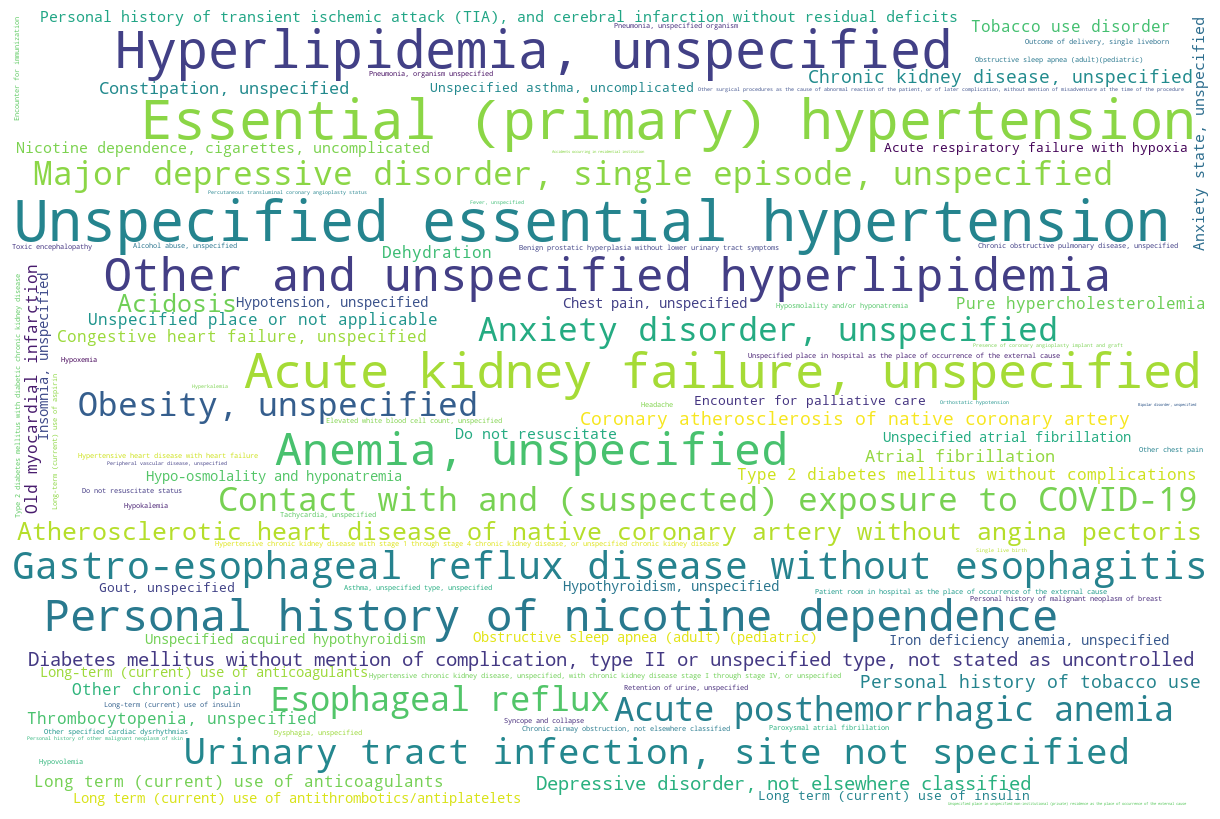

In [21]:
generate_complete_summary(
    diagnoses_icd_file, 
    data_dictionary_icd,
    patient_id_col = "subject_id",
    code_cols= {"code": "icd_code", "code_version":"icd_version"},
    cols_to_summarize=["subject_id","icd_code","icd_version"],
    code_desc_column ="long_title",
    summary_directory=summary_directory,
    batch_size=5000000
)

In [22]:
base_directory = os.path.dirname(os.getcwd())
hcpcsevents_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","hcpcsevents.csv")
summary_directory = os.path.join(base_directory, 'processed_data', 'Summary')
print("Top 5 rows of the HCPCSevents file: ")
display(pd.read_csv(hcpcsevents_file,dtype=str, nrows=5))

d_hcpcsevents_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp", "d_hcpcs.csv")
data_dictionary_hcpcs = pd.read_csv(d_hcpcsevents_file,dtype=str)
print("Top 5 rows of the HCPCSevent description file: ")
display(data_dictionary_hcpcs.head())

# We need to have the same column names for code to perform the join operation
data_dictionary_hcpcs=data_dictionary_hcpcs.rename(columns={"code":"hcpcs_cd"})
display(data_dictionary_hcpcs.head())

Top 5 rows of the HCPCSevents file: 


,subject_id,hadm_id,chartdate,hcpcs_cd,seq_num,short_description
0,10000068,25022803,2160-03-04,99218,1,Hospital observation services
1,10000084,29888819,2160-12-28,G0378,1,Hospital observation per hr
2,10000108,27250926,2163-09-27,99219,1,Hospital observation services
3,10000117,22927623,2181-11-15,43239,1,Digestive system
4,10000117,22927623,2181-11-15,G0378,2,Hospital observation per hr


Top 5 rows of the HCPCSevent description file: 


,code,category,long_description,short_description
0,00000,NaN,NaN,Invalid Code
1,0001F,2,NaN,Composite measures
2,0002F,2,NaN,Composite measures
3,0003F,2,NaN,Composite measures
4,0004F,2,NaN,Composite measures


,hcpcs_cd,category,long_description,short_description
0,00000,NaN,NaN,Invalid Code
1,0001F,2,NaN,Composite measures
2,0002F,2,NaN,Composite measures
3,0003F,2,NaN,Composite measures
4,0004F,2,NaN,Composite measures


Total Rows in file: 186074
Most frequent values under each column:


,subject_id,subject_id_count,chartdate,chartdate_count,hcpcs_cd,hcpcs_cd_count
0,15496609,227,2179-03-13,32,G0378,68571
1,15464144,185,2183-11-19,28,99219,52408
2,10714009,150,2173-11-02,28,99218,12091
3,15229574,127,2177-08-16,28,99220,11069
4,14394983,125,2179-07-07,27,44970,1174


Processing chunks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.24it/s]


Most frequent codes and their corresponding patient counts


,hcpcs_cd,counts,category,long_description,short_description
0,G0378,39829,NaN,"Hospital observation service, per hour",Hospital observation per hr
1,99219,39387,1,NaN,Hospital observation services
2,99218,10458,1,NaN,Hospital observation services
3,99220,8354,1,NaN,Hospital observation services
4,44970,1174,1,NaN,Digestive system


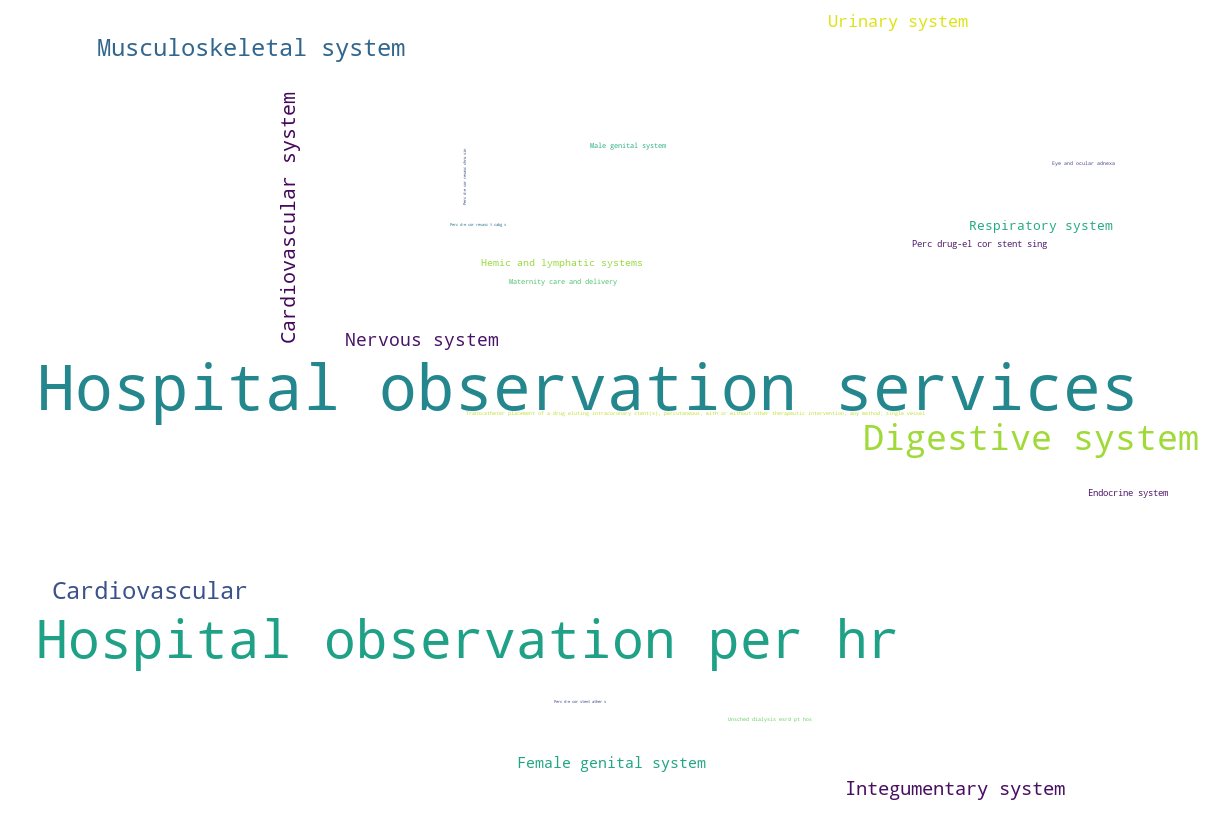

In [23]:
generate_complete_summary(
    hcpcsevents_file, 
    data_dictionary_hcpcs,
    patient_id_col = "subject_id",
    code_cols= {"code": "hcpcs_cd"},
    cols_to_summarize=["subject_id","hcpcs_cd","chartdate"],
    code_desc_column = "short_description",
    summary_directory=summary_directory,
    batch_size=5000000
)

In [24]:
base_directory = os.path.dirname(os.getcwd())
procedures_icd_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","procedures_icd.csv")
summary_directory = os.path.join(base_directory, 'processed_data', 'Summary')
print("Top 5 rows of the ICD Procedures file: ")
display(pd.read_csv(procedures_icd_file,dtype=str, nrows=5))

d_icd_procedure_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp", "d_icd_procedures.csv")
d_icd_procedure = pd.read_csv(d_icd_procedure_file,dtype=str)
print("Top 5 rows of the ICD Procedure descriptions file: ")
display(d_icd_procedure.head())

Top 5 rows of the ICD Procedures file: 


,subject_id,hadm_id,seq_num,chartdate,icd_code,icd_version
0,10000032,22595853,1,2180-05-07,5491,9
1,10000032,22841357,1,2180-06-27,5491,9
2,10000032,25742920,1,2180-08-06,5491,9
3,10000068,25022803,1,2160-03-03,8938,9
4,10000117,27988844,1,2183-09-19,0QS734Z,10


Top 5 rows of the ICD Procedure descriptions file: 


,icd_code,icd_version,long_title
0,0001,9,Therapeutic ultrasound of vessels of head and neck
1,0002,9,Therapeutic ultrasound of heart
2,0003,9,Therapeutic ultrasound of peripheral vascular vessels
3,0009,9,Other therapeutic ultrasound
4,001,10,"Central Nervous System and Cranial Nerves, Bypass"


Total Rows in file: 859655
Most frequent values under each column:


,subject_id,subject_id_count,icd_code,icd_code_count,icd_version,icd_version_count
0,17295976,350,3893,14644,9,469209.0
1,19530208,199,02HV33Z,14353,10,390446.0
2,13475033,174,8938,10519,NaN,NaN
3,14873669,157,3897,10347,NaN,NaN
4,18553055,148,8856,9549,NaN,NaN


Processing chunks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


Most frequent codes and their corresponding patient counts


,icd_code,icd_version,counts,long_title
0,02HV33Z,10,11227,"Insertion of Infusion Device into Superior Vena Cava, Percutaneous Approach"
1,3893,9,10159,"Venous catheterization, not elsewhere classified"
2,8938,9,8807,Other nonoperative respiratory measurements
3,8856,9,7861,Coronary arteriography using two catheters
4,3897,9,7385,Central venous catheter placement with guidance


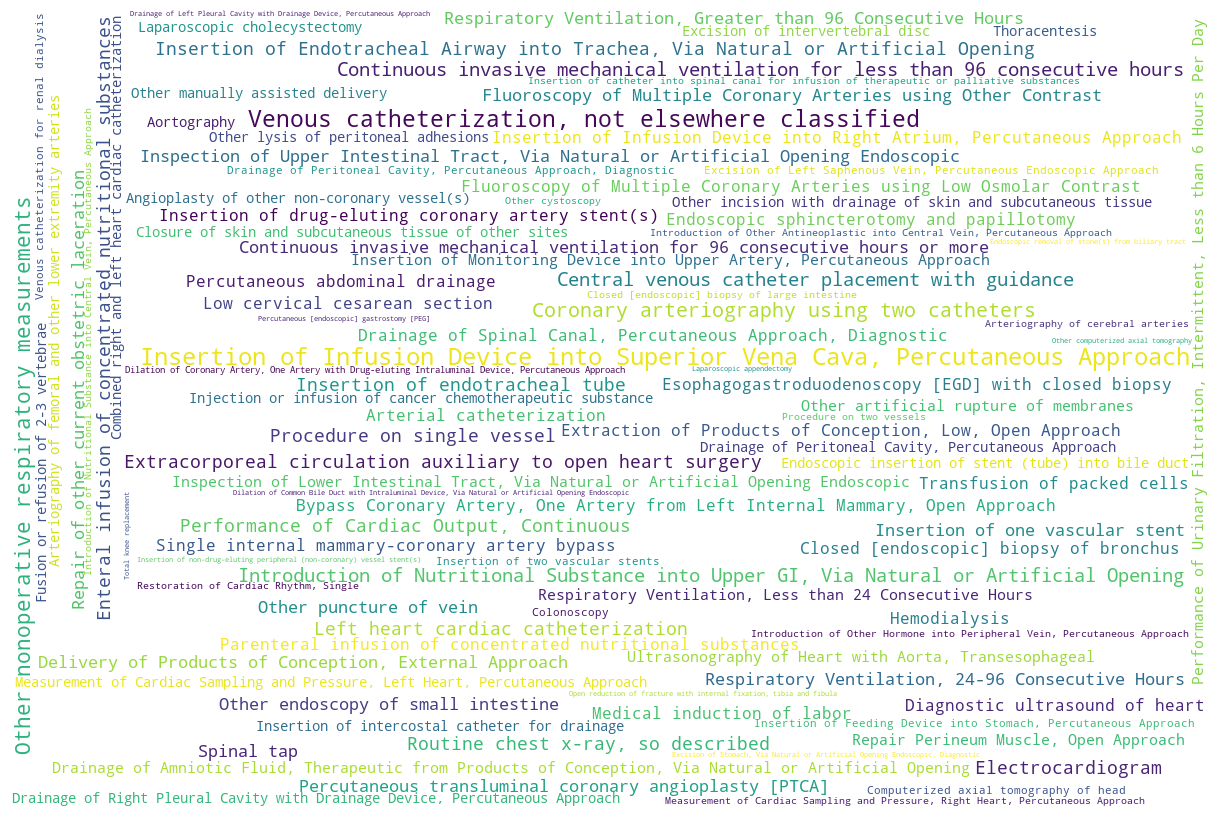

In [25]:
generate_complete_summary(
    procedures_icd_file, 
    d_icd_procedure,
    patient_id_col = "subject_id",
    code_cols= {"code": "icd_code", "code_version":"icd_version"},
    cols_to_summarize=["subject_id","icd_code","icd_version"],
    summary_directory=summary_directory,
    code_desc_column="long_title",
    batch_size=5000000
)

In [27]:
base_directory = os.path.dirname(os.getcwd())
prescriptions_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp","prescriptions.csv")
summary_directory = os.path.join(base_directory, 'processed_data', 'Summary')
print("Top 5 rows of the Prescription file: ")
display(pd.read_csv(prescriptions_file,dtype=str, nrows=5))

# We don't have a description file for NDC, so we create one based on the mapping provided inside the prescription file
d_prescription = pd.read_csv(prescriptions_file,dtype=str, usecols=['ndc','drug'])
d_prescription.drop_duplicates(subset=['ndc'],keep='first',inplace=True)
display(d_prescription)

Top 5 rows of the Prescription file: 


,subject_id,hadm_id,pharmacy_id,poe_id,poe_seq,order_provider_id,starttime,stoptime,drug_type,drug,formulary_drug_cd,gsn,ndc,prod_strength,form_rx,dose_val_rx,dose_unit_rx,form_val_disp,form_unit_disp,doses_per_24_hrs,route
0,10000032,22595853,12775705,10000032-55,55,P85UQ1,2180-05-08 08:00:00,2180-05-07 22:00:00,MAIN,Furosemide,FURO40,008209,51079007320,40mg Tablet,NaN,40,mg,1,TAB,1,PO/NG
1,10000032,22595853,18415984,10000032-42,42,P23SJA,2180-05-07 02:00:00,2180-05-07 22:00:00,MAIN,Ipratropium Bromide Neb,IPRA2H,021700,00487980125,2.5mL Vial,NaN,1,NEB,1,VIAL,4,IH
2,10000032,22595853,23637373,10000032-35,35,P23SJA,2180-05-07 01:00:00,2180-05-07 09:00:00,MAIN,Furosemide,FURO20,008208,51079007220,20mg Tablet,NaN,20,mg,1,TAB,1,PO/NG
3,10000032,22595853,26862314,10000032-41,41,P23SJA,2180-05-07 01:00:00,2180-05-07 01:00:00,MAIN,Potassium Chloride,MICROK10,001275,00245004101,10mEq ER Tablet,NaN,40,mEq,4,TAB,1,PO
4,10000032,22595853,30740602,10000032-27,27,P23SJA,2180-05-07 00:00:00,2180-05-07 22:00:00,MAIN,Sodium Chloride 0.9% Flush,NACLFLUSH,NaN,0,10 mL Syringe,NaN,3,mL,0.3,SYR,3,IV


Top 5 rows of the Prescription description file: 


,drug,ndc
0,Furosemide,51079007320
1,Ipratropium Bromide Neb,00487980125
2,Furosemide,51079007220
3,Potassium Chloride,00245004101
4,Sodium Chloride 0.9% Flush,0
...,...,...
20148201,diclofenac sodium,00115148361
20163079,Droperidol,00074118701
20180104,Flovent HFA,00173071820
20223809,Chromium Chloride,00409409301


Total Rows in file: 20292611
Most frequent values under each column:


,subject_id,subject_id_count,drug,drug_count,ndc,ndc_count
0,12468016,8269,Insulin,845166,0,2518625
1,10913302,5769,0.9% Sodium Chloride,728089,00338004904,384236
2,11389314,5552,Potassium Chloride,674552,63323026201,316791
3,10577647,5397,Sodium Chloride 0.9% Flush,673380,00338011704,292265
4,12294892,5302,Acetaminophen,586860,00409672924,227783


Processing chunks: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:30<00:00,  6.05s/it]


Most frequent codes and their corresponding patient counts


,ndc,counts,drug
0,0,188786,Sodium Chloride 0.9% Flush
1,63323026201,112309,Heparin
2,00904224461,100746,Docusate Sodium
3,00338011704,97663,Lactated Ringers
4,00338004904,91143,Sodium Chloride 0.9%


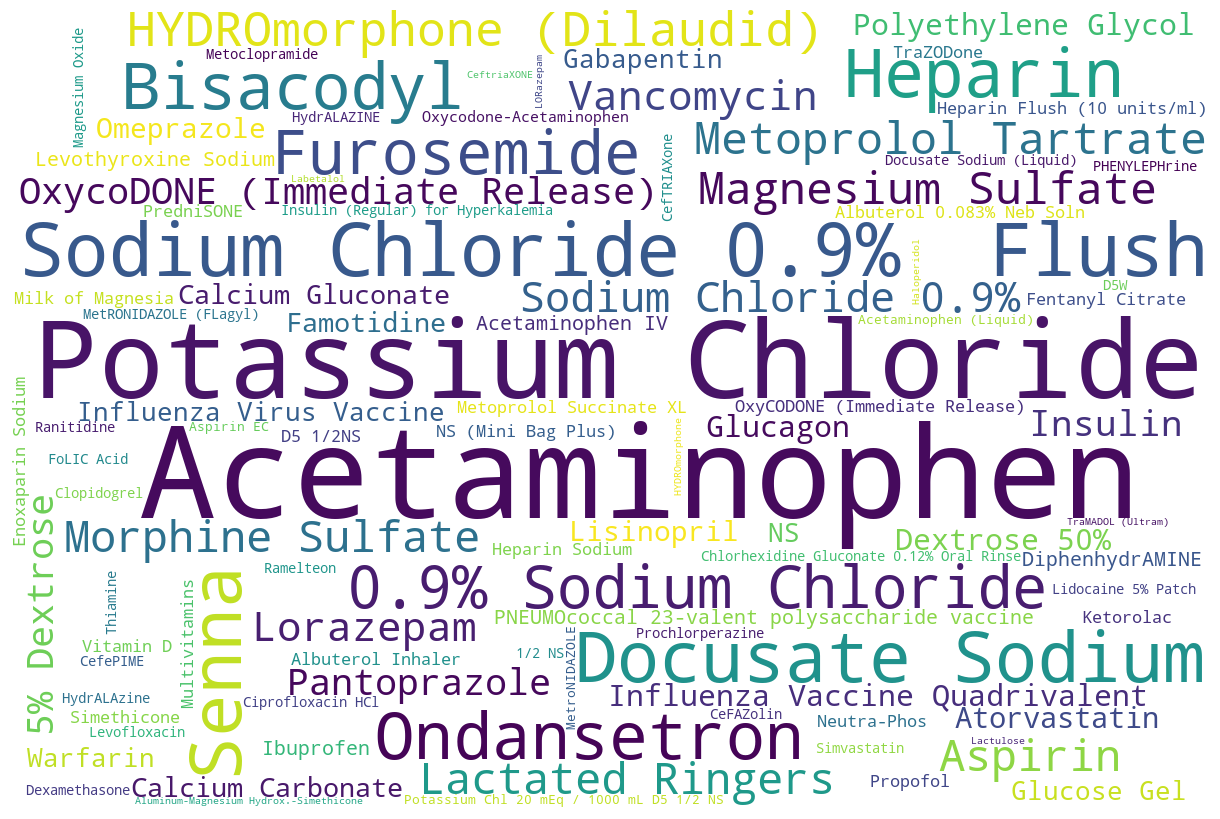

In [28]:
generate_complete_summary(
    prescriptions_file, 
    d_prescription,
    patient_id_col = "subject_id",
    code_cols= {"code": "ndc"},
    cols_to_summarize=["subject_id","ndc","drug"],
    summary_directory=summary_directory,
    code_desc_column="drug",
    batch_size=5000000
)

In [29]:
base_directory = os.path.dirname(os.getcwd())
labitems_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp", "labevents.csv")
summary_directory = os.path.join(base_directory, 'processed_data', 'Summary')
print("Top 5 rows of labitems file: ")
display(pd.read_csv(labitems_file,dtype=str, nrows=5))

d_labitems_file = os.path.join(base_directory, "raw_data", "physionet.org", "files", "mimiciv", "3.1", "hosp", "d_labitems.csv")
print("Top 5 rows of labitems descriptions file: ")
d_labitems = pd.read_csv(d_labitems_file,dtype=str)
display(d_labitems.head())

Top 5 rows of labitems file: 


,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,1,10000032,NaN,2704548,50931,P69FQC,2180-03-23 11:51:00,2180-03-23 15:56:00,___,95,mg/dL,70,100,NaN,ROUTINE,"IF FASTING, 70-100 NORMAL, >125 PROVISIONAL DIABETES."
1,2,10000032,NaN,36092842,51071,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,NaN
2,3,10000032,NaN,36092842,51074,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,NaN
3,4,10000032,NaN,36092842,51075,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,"BENZODIAZEPINE IMMUNOASSAY SCREEN DOES NOT DETECT SOME DRUGS,;INCLUDING LORAZEPAM, CLONAZEPAM, AND FLUNITRAZEPAM."
4,5,10000032,NaN,36092842,51079,P69FQC,2180-03-23 11:51:00,2180-03-23 16:00:00,NEG,NaN,NaN,NaN,NaN,NaN,ROUTINE,NaN


Top 5 rows of labitems descriptions file: 


,itemid,label,fluid,category
0,50801,Alveolar-arterial Gradient,Blood,Blood Gas
1,50802,Base Excess,Blood,Blood Gas
2,50803,"Calculated Bicarbonate, Whole Blood",Blood,Blood Gas
3,50804,Calculated Total CO2,Blood,Blood Gas
4,50805,Carboxyhemoglobin,Blood,Blood Gas


Total Rows in file: 158374764
Most frequent values under each column:


,subject_id,subject_id_count,itemid,itemid_count
0,12468016,44132,51221,4331615
1,13198542,38225,50912,4319091
2,10913302,36568,51265,4214048
3,12294892,36175,51006,4202807
4,18904293,33869,51222,4181121


Processing chunks: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [02:43<00:00, 14.87s/it]


Most frequent codes and their corresponding patient counts


,itemid,counts,label,fluid,category
0,51221,298904,Hematocrit,Blood,Hematology
1,51265,298654,Platelet Count,Blood,Hematology
2,51222,298632,Hemoglobin,Blood,Hematology
3,51301,298581,White Blood Cells,Blood,Hematology
4,51279,298570,Red Blood Cells,Blood,Hematology


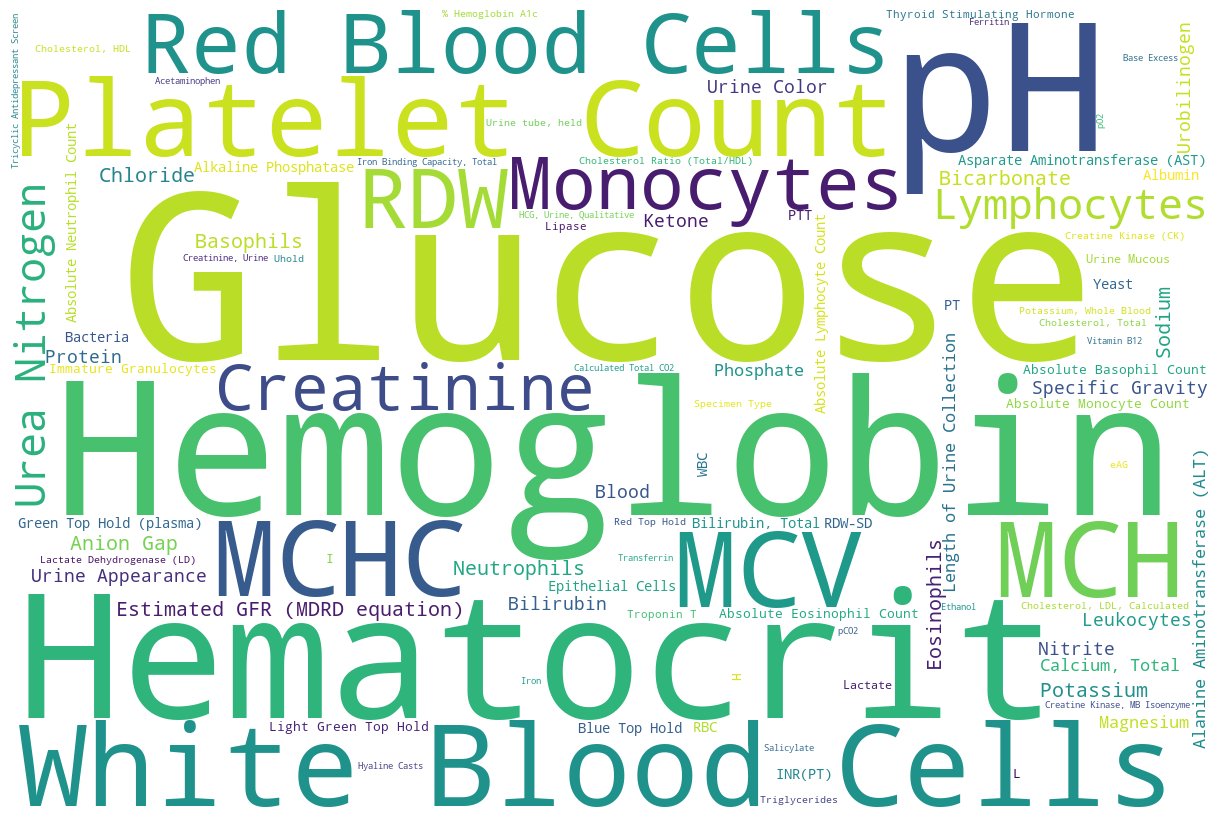

In [30]:
generate_complete_summary(
    labitems_file, 
    d_labitems,
    patient_id_col = "subject_id",
    code_cols= {"code": "itemid"},
    cols_to_summarize=["subject_id","itemid"],
    summary_directory=summary_directory,
    code_desc_column="label",
    batch_size=15000000
)

At the end of the notebook, you will have the following summary files generated under your EHR_TUTORIAL_WORKSPACE/processed_data/Summary 

`diagnoses_basic_summary.csv`  
`diagnoses_icd_basic_summary.csv`  
`diagnoses_icd_most_freq_items.csv`  
`diagnoses_icd_wordcloud.png`  
`diagnoses_patient_count.csv`  
`hcpcsevents_basic_summary.csv`  
`hcpcsevents_most_freq_items.csv`  
`hcpcsevents_wordcloud.png`  
`labevents_most_freq_items.csv`  
`labevents_wordcloud.png`  
`prescriptions_basic_summary.csv`  
`prescriptions_most_freq_items.csv`  
`prescriptions_wordcloud.png`  
`procedures_icd_basic_summary.csv`  
`procedures_icd_most_freq_items.csv`  
`procedures_icd_wordcloud.png`